In [173]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import randint
#  from scipy.stats import bernoulli

In [174]:
def simulate_single(x):
    S0=30
    r=0.06
    t=6 # number of periods
    u=1+r+math.sqrt((1+r)**2-1) 
    drift=0
    vol=x # for additive amount, how much to add
    d=(1+r)/u
    face=50
    coupon_rate = 0.04
    coupon = coupon_rate*face  
    default_threshold = 1/4
    bankrupcy_ratio = 2.4
    K=55 # call value
    
    def g(x): # payoff function e.g for a call it would be max(0, x-K)
        if x==0:
            return [0, 0]
        if x <= default_threshold*S0:
            return [x*bankrupcy_ratio, 0]
        return [face, coupon] # first entry is the actual value, second is dividends or coupons
    
    # p=0.5#(1+r-d)/(u-d)
    # q=1-p
    # p=1-q # fixes floating-point errors hopefully
    # print(p, q) # only use these in the multiplicative model
    
    def nSigFigs(num, n):
        #print(num == np.nan)
        if type(num) not in [float, int, np.float64] or num == float("NaN"): return float("NaN")
        return int(num * 10**n) / 10**n
    
    def displayChart(tab):
        Chart=[]
        columns = []
        N = len(tab)-1
        for i in range(N, -1, -1):
            chart = []
            columns.append(N-i)
            for j in range(0,i):
                chart.append("")
            for j in range(i, N+1):
                entry = tab[j][i]
                chart.append(entry)
            Chart.append(chart)
        df = pd.DataFrame(Chart, columns = columns)
        return df.style.hide_index()
    
    def r_values(drift, vol):
        R = {}
        for i in range(t, -1, -1):
            R[i] = r + i*drift - vol*np.arange(i, -1, -1) + vol*np.arange(0, i+1, 1)
        return R
    
    rates = r_values(0, 0.005)
    # print("interest rates")
    # displayChart(rates)

    interests = {}
    for key in range(0, t+1, 1):
        interests[key] = [0]*(key+1)
        for j in range(0, key+1, 1):
            index = randint(0, key)
            interests[key][j] = rates[key][index]

    
    def StockPrice(mode='a'): # a for additive, m for multiplicative
        StockPrice={}
        if mode == 'm':
            for i in range(t, -1, -1):
                StockPrice[i] = S0 * d ** (np.arange(i,-1,-1)) * u ** (np.arange(0,i+1,1)) #np.empty(N+1)

        elif mode == 'a':
            for i in range(t, -1, -1):
                StockPrice[i] = np.maximum(np.zeros(i+1), S0 + i*drift - vol*np.arange(i, -1, -1) + vol*np.arange(0,i+1,1))

        return StockPrice

    SP = StockPrice()
    # print("stock price")
    # displayChart(SP)
    
    def p_values(stock_price_chart, interests):
        P = {i: [1]*(i+1) for i in range(t+1)}
        for i in range(0, t):
            for j in range(i+1):
                if stock_price_chart[i][j] == 0:
                    P[i][j] = -1
                else:
                    d = stock_price_chart[i+1][j] / stock_price_chart[i][j]
                    u = stock_price_chart[i+1][j+1] / stock_price_chart[i][j]
                    P[i][j] = (1 + interests[i][j] - d) / (u-d)
        return P

    p_vals = p_values(SP, interests)
    # print("p tilde")
    # displayChart(p_vals)
    
    def exp(x,y,p,r):
        if p != -1:
            return (x*p+y*(1-p))/(1+r)
        return 0

    # multiplicative model
    def rnExp(x,y):
        return exp(x,y,p,r)
    
        
    bond_payoff = list(map(g, SP[t]))
    def vanillaBond(payoff): # coupon amount
        vanillaBond={}
        vanillaBond[t]=bond_payoff
        #IP=IntrinsicPut()
        #for n in range(0, N+1):
        #    PutPriceA[N].append(IP[N][n])
        for i in range(t-1, -1, -1):
            vanillaBond[i]=[]
            for j in range(i+1):
                entry = [0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(vanillaBond[i+1][j+1][0], vanillaBond[i+1][j][0], p_vals[i][j], interests[i][j]) + exp(vanillaBond[i+1][j+1][1], vanillaBond[i+1][j][1], p_vals[i][j], interests[i][j])
                    entry[0] = entry[0]
                    entry[1] = coupon if ((SP[i][j] >= default_threshold or i<t) and i>0) else 0
                #print(entry)
                vanillaBond[i].append(entry)
        return vanillaBond

    vBond = vanillaBond(bond_payoff)
    # print("Vanilla Bond payoff: [face value (after coupon), coupon]")
    # displayChart(vBond)

    def convBond(payoff):
        convBond = {}
        convBond[t] = [[max(SP[t][i], payoff[i][0]), payoff[i][1]] for i in range(t+1)]
        for i in range(t-1, -1, -1):
            convBond[i]=[]
            for j in range(i+1):
                entry = [0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(convBond[i+1][j+1][0], convBond[i+1][j][0], p_vals[i][j], interests[i][j]) \
                            + exp(convBond[i+1][j+1][1], convBond[i+1][j][1], p_vals[i][j], interests[i][j])
                    entry[0] = max(entry[0], SP[i][j])
                    entry[1] = coupon if SP[i][j] >= default_threshold or i<t else 0
                #print(entry)
                convBond[i].append(entry)
        convBond[0][0][1]=0
        return convBond
    
    cBond = convBond(bond_payoff)
    # print("Convertible Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible but not callable")
    # displayChart(cBond)


    #conv_payoff: dictionary of convertible prices
    #strike: strike price
    def fill_payoff(payoff, time):
        for i in range(time-1, -1, -1):
            payoff[i] = []
            for j in range(i+1):
                entry = [0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(payoff[i+1][j+1][0], payoff[i+1][j][0], p_vals[i][j], rates[i][j]) + exp(payoff[i+1][j+1][1], payoff[i+1][j][1], p_vals[i][j], rates[i][j])
                    entry[0] = entry[0]
                    entry[1] = coupon if (SP[i][j] >= default_threshold or i<t) and i>0 else 0
                payoff[i].append(entry)
        return payoff
        

    def callable(conv, strike):
        callable_prices = []
        for i in range(t-1, -1, -1):    #i: time step
            for j in range(i+1):        #j: # of nodes at time
                if conv[i][j][0] >= strike:
                    old_val = conv[i][j][0]
                    conv[i][j][0] = strike
                    #continue etc
                    new_prices = {}
                    new_prices[i] = []
                    for k in range(i+1):
                        entry = conv[i][k]
                        new_prices[i].append(entry)
                    #new_prices has one key i, and a list of length j
                    new_prices = fill_payoff(new_prices, i)
                    b_0 = new_prices[0][0][0]
                    callable_prices.append(b_0)
                    conv[i][j][0] = old_val
        return callable_prices
    
    v_val = vBond[0][0]
    c_val = cBond[0][0]
    # print(v_val, c_val)

    callable_prices_list = callable(cBond, K)
    if(callable_prices_list): min_price = min(callable_prices_list)
    else: min_price = c_val[0]

    return [v_val[0]+v_val[1], c_val[0]+c_val[1], min_price]

simulate_single(5)

[45.74044770986395, 46.77182294735521, 44.89447166835664]

In [175]:
runs = 5 # number of simulations at each vol (how much to increase/decrease in the additive model)
lo = 2 # lowest vol
hi = 9 # highest vol
incr = -0.1 # negative

keys = np.arange(hi, lo, incr)
v_price = {}
c_price = {}
callable_price = {}

for i in keys: # try different vol 
    v_price[i] = ([0]*runs)
    c_price[i] = ([0]*runs)
    callable_price[i] = ([0]*runs)
    for j in range(0, runs, 1): 
        (v_price[i][j], c_price[i][j], callable_price[i][j]) = simulate_single(i)

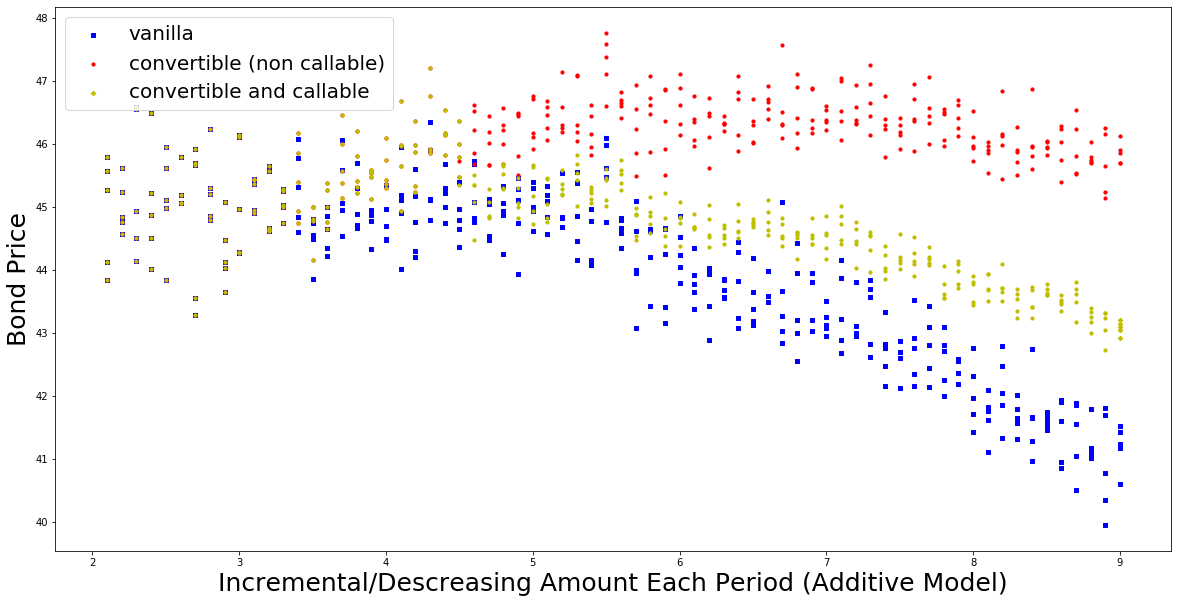

In [176]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot()
plt.xlabel('Incremental/Descreasing Amount Each Period (Additive Model)', fontsize = 25) 
plt.ylabel('Bond Price', fontsize = 25) 

for key in v_price:
    if(key == lo or key == hi):
        ax1.scatter([key]*runs, v_price[key], s=10, c='b', marker="s", label="vanilla")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o", label="convertible (non callable)")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y', marker="D", label="convertible and callable")
    else:
        ax1.scatter([key]*runs, v_price[key], s=10, c='b', marker="s")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y')


plt.legend(loc='upper left', fontsize = 20)
plt.show()
                